In [17]:
import pandas as pd
import seaborn as sns
import sys
import os

# add parent directory to sys.path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from lib.functions import *

In [18]:
df = pd.read_csv("../data/diabetes_prediction_dataset.csv")

### Data Cleaning

In [19]:
# drop rows
df=df.loc[df['smoking_history'] != 'No Info']
df=df.loc[df['gender'] != 'Other']

# aggregate values
df['smoking_history'].loc[df["smoking_history"] == 'not current'] = 'former'

<Axes: xlabel='bmi', ylabel='Count'>

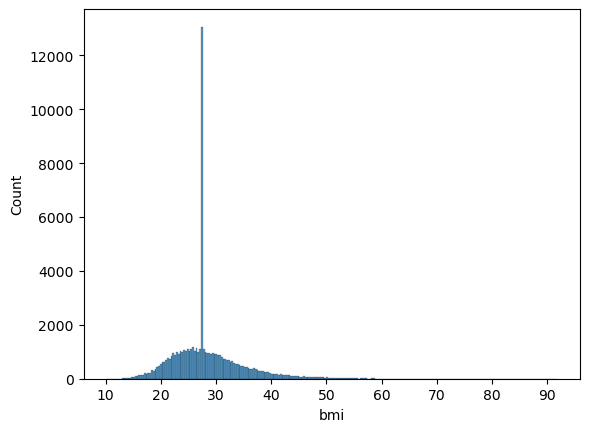

In [20]:
sns.histplot(df, x='bmi')

In [21]:
df.loc[df['bmi'] == 27.32].shape

(12045, 9)

In [22]:
df['bmi'].describe()

count    64172.000000
mean        28.424262
std          6.515975
min         10.080000
25%         24.600000
50%         27.320000
75%         31.100000
max         91.820000
Name: bmi, dtype: float64

<Axes: xlabel='blood_glucose_level', ylabel='Count'>

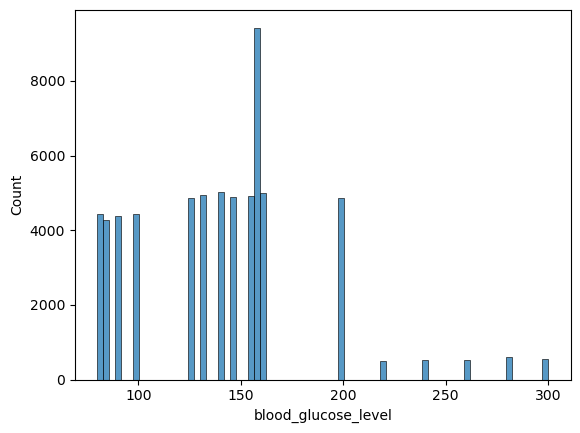

In [23]:
sns.histplot(df, x='blood_glucose_level')

In [24]:
df['blood_glucose_level'].mode()

0    140
Name: blood_glucose_level, dtype: int64

In [25]:
df['blood_glucose_level'].value_counts()

140    5025
160    4998
159    4968
130    4957
155    4923
145    4878
126    4876
200    4873
158    4460
80     4434
100    4431
90     4384
85     4274
280     599
300     547
260     526
240     518
220     501
Name: blood_glucose_level, dtype: int64

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64172 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               64172 non-null  object 
 1   age                  64172 non-null  float64
 2   hypertension         64172 non-null  int64  
 3   heart_disease        64172 non-null  int64  
 4   smoking_history      64172 non-null  object 
 5   bmi                  64172 non-null  float64
 6   HbA1c_level          64172 non-null  float64
 7   blood_glucose_level  64172 non-null  int64  
 8   diabetes             64172 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 4.9+ MB


### Feature Engineering

In [27]:
# transform categorical columns to numerical
df["smoking_history"] = df["smoking_history"].map({'never': 0, 'former': 1, 'current': 2, 'ever': 3})
df = pd.get_dummies(df, columns=['gender'])

In [28]:
df.head(3)

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male
0,80.0,0,1,0,25.19,6.6,140,0,1,0
2,28.0,0,0,0,27.32,5.7,158,0,0,1
3,36.0,0,0,2,23.45,5.0,155,0,1,0


In [29]:
# define features and target
features = df.drop(columns = ["diabetes"])
target = df["diabetes"]

<Axes: >

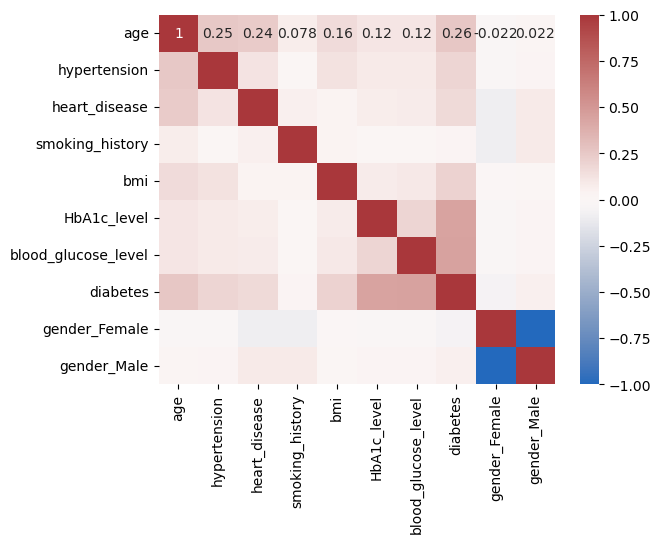

In [38]:
# create correlation heatmap
corr = df.corr()
sns.heatmap(corr, vmin = -1, vmax = 1, annot=True, cmap='vlag')

In [ ]:
# split data into training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)

In [13]:
# normalize features

from sklearn.preprocessing import MinMaxScaler, StandardScaler
#normalizer = MinMaxScaler()
normalizer = StandardScaler()

X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

pd.DataFrame(X_train_norm).head(3)

,0,1,2,3,4,5,6,7,8
0,1.711181,-0.330016,-0.221988,-0.779612,-1.234008,0.213543,0.009041,0.805349,-0.805349
1,-0.078604,-0.330016,-0.221988,-0.779612,2.184139,-0.972220,0.483487,0.805349,-0.805349
2,-0.129741,-0.330016,-0.221988,1.373027,-0.172149,0.578393,0.127653,0.805349,-0.805349


### Model Training and Evaluation

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define models
models = {
  'Decision Tree': DecisionTreeClassifier(random_state=42),
  'Random Forest': RandomForestClassifier(random_state=42),
  'KNN': KNeighborsClassifier()
}

# Train and evaluate models
results = {}

for name, model in models.items():
  # Train the model
  model.fit(X_train_norm, y_train)
  
  # Make predictions
  y_pred = model.predict(X_test_norm)
  
  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred)
  
  # Store results
  results[name] = accuracy

In [15]:
for name, result in results.items():
    print(f'{name} \naccuracy: {round(result, 2)}')
    print('')

Decision Tree 
accuracy: 0.94

Random Forest 
accuracy: 0.96

KNN 
accuracy: 0.95



* Cross Validation
* Correlation test
* dummies for 'smoking history'
* PCA
* Outliers
* other KPIs? (MSE, ...)

Questions:
* Outliers